# LIBRERIAS

In [5]:
import numpy as np
import pandas as pd
from itertools import product
from sympy.physics.quantum.cg import CG, cg_simp
from sympy import Symbol,symbols,sqrt,sin,cos,simplify,latex,diff

# BOSON DEFINITION

In [6]:
# define boson
class boson_creation(object):
    """this is a test"""
    def __init__(self, l):
        self.l = l
        self.m = np.array([m for m in range(-l,l+1,1)])
        self.len = len(self.m)
        self.coef = np.array([1 for m in range(-l,l+1,1)])
        # representation
        if (l==0):
            boson_type = 's'
        elif (l==2):
            boson_type = 'd'
        elif (l==1):
            boson_type = 'p'
        elif (l==3):
            boson_type = 'f'
        else:
            boson_type = 'bt'+str(l)
        self.boson_type = boson_type
        self.representation = np.array(symbols(boson_type +'t(1:'+str(2*l+1+1)+')'))
        

class boson_annihilation(object):
    """this is a test"""
    def __init__(self, l):
        self.l = l
        self.m = np.array([m for m in range(l,-l-1,-1)])
        self.len = len(self.m)
        self.coef = np.array([(-1)**(self.l+m) for m in range(-l,l+1,1)])
        # representation
        if (l==0):
            boson_type = 's'
        elif (l==2):
            boson_type = 'd'
        elif (l==1):
            boson_type = 'p'
        elif (l==3):
            boson_type = 'f'
        else:
            boson_type = 'b'+str(l)
        self.boson_type = boson_type
        repre = symbols(boson_type +'(1:'+str(2*l+1+1)+')')
        self.representation = np.array(list(reversed(repre)))

# FUCTIONS

### INNER PRODUCT DEFINITION
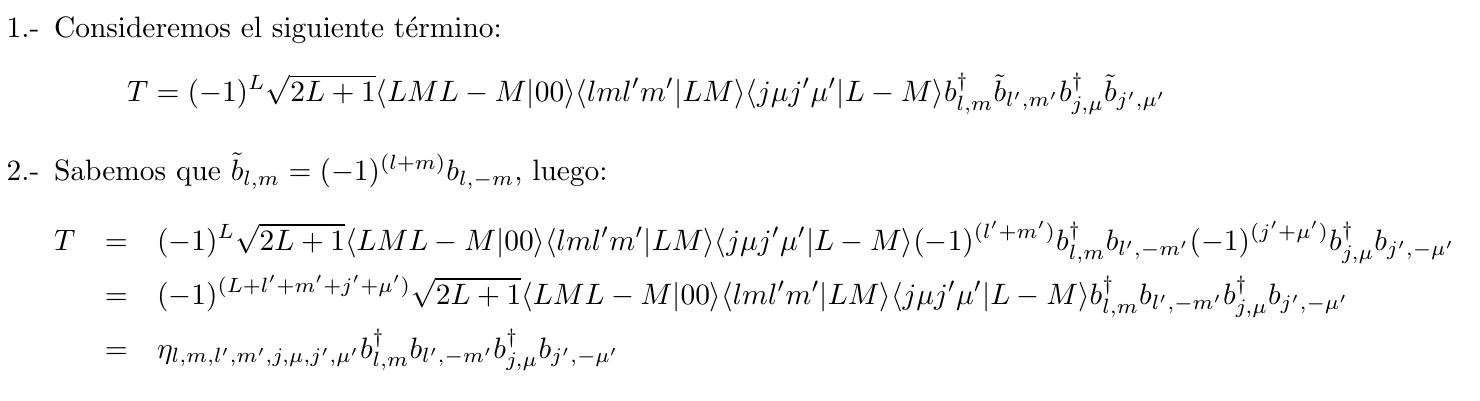

In [7]:
def m_extract(x):
    #extract m component of boson representation
    if (str(x)[0]=='d'):
        return int(str(x)[-1])-2-1
    elif (str(x)[0]=='s'):
        return int(str(x)[-1])-0-1
    elif (str(x)[0]=='p'):
        return int(str(x)[-1])-1-1
    elif (str(x)[0]=='f'):
        return int(str(x)[-1])-3-1
    
def L_assign(x):
    #assign total angular momentum
    if (str(x)[0]=='d'):
        return 2
    elif (str(x)[0]=='s'):
        return 0
    elif (str(x)[0]=='p'):
        return 1
    elif (str(x)[0]=='f'):
        return 3

def cg(L1,m1,L2,m2,L):
    #assing total angular momentum
    #return clebsh-gordan coeff
    return CG(L1,m1,L2,m2,L,m1+m2).doit()

def phase(x,y):
    L = L_assign(x)
    return (-1)**(L+y)


def one_body_product(x,y,L):
    df  = pd.DataFrame(columns=['first','second'],data=product(x.representation,y.representation))
    #extract m component
    df['L1'] = df['first'].apply(lambda x: L_assign(x))
    df['L2'] = df['second'].apply(lambda x: L_assign(x))
    df['m1'] = df['first'].apply(m_extract)
    df['m2'] = df['second'].apply(m_extract)
    #phase tilde boson
    df['phase'] = df.apply(lambda x: phase(x['second'],x['m2']), axis=1)
    #clebsh-gordon generation
    df['cg1'] = df.apply(lambda x: cg(x['L1'],x['m1'],x['L2'],x['m2'],L), axis=1)
    # get the L1 values for use sympy.sqrt() function
    df['sqrt'] = df['L1'].apply(lambda x: sqrt(2*x+1))
    df['total'] = ((-1)**(df['L1']) )*(df['sqrt'])*df['cg1']*df['first']*df['second']*df['phase']
    total = df['total'].sum()
    return df,total

def two_body_product(x1,y1,x2,y2,L):
    # proto function for two body operators 
    # one-body multiplication
    first_prod  = product(x1.representation,y1.representation)
    second_prod = product(x2.representation,y2.representation)
    # two-body multiplication
    prod = list(product(first_prod,second_prod))
    # create dataframa
    df  = pd.DataFrame(columns=['0','1'],data=prod)
    # extract bosons
    df['first']  = df['0'].apply(lambda x: x[0])
    df['second'] = df['0'].apply(lambda x: x[1])
    df['three']  = df['1'].apply(lambda x: x[0])
    df['four']   = df['1'].apply(lambda x: x[1])
    df.drop(columns=['0','1'],inplace=True)
    # extract total angular momentum
    df['L1'],df['L2'] = df['first'].apply(lambda x: L_assign(x)), df['second'].apply(lambda x: L_assign(x))
    df['L3'],df['L4'] = df['three'].apply(lambda x: L_assign(x)), df['four'].apply(lambda x: L_assign(x))
    # extract project angular momentum
    df['m1'],df['m2'] = df['first'].apply(m_extract), df['second'].apply(m_extract)
    df['m3'],df['m4'] = df['three'].apply(m_extract), df['four'].apply(m_extract)
    # momentum of operator
    df['L'] = L
    # phase tilde operator
    df['phase2'] = df.apply(lambda x: phase(x['second'],x['m2']), axis=1)
    df['phase4'] = df.apply(lambda x: phase(x['four']  ,x['m4']), axis=1)
    # clebsh-gordan boson:1y2
    df['cg12'] = df.apply(lambda x: cg(x['L1'],x['m1'],x['L2'],x['m2'],x['L']), axis=1)
    # clebsh-gordon boson:3y4
    df['cg34'] = df.apply(lambda x: cg(x['L3'],x['m3'],x['L4'],x['m4'],x['L']), axis=1)
    # sum projection
    df['m1_plus_m2'] = df['m1']+df['m2']
    # look definition
    df['m3_plus_m4'] = -df['m3']-df['m4']
    # conmutation rules [bt_im,b_jn] = delta_{ij}delta_{mn}
    df['conmutation_second_three'] = 0 
    df.loc[(df['L2']==df['L3'])&(df['m2']==df['m3']),'conmutation_second_three']=1
    # clebsh-gordon inner dot 
    df['cg']   = df.apply(lambda x: cg(x['L'],x['m1_plus_m2'],x['L'],x['m3_plus_m4'],L=0), axis=1)
    df['sqrt'] = df['L'].apply(lambda x: sqrt(2*x+1))
    #total
    df['total1'] = ((-1)**(df['L']) )*(df['sqrt'])* (df['cg']) *(df['cg12']*df['first']*df['second']*df['phase2'])*(df['cg34']*df['three']*df['four']*df['phase4'])
    df['total2'] = ((-1)**(df['L']) )*(df['sqrt'])* (df['conmutation_second_three'])* (df['cg']) *(df['cg12']*df['first']*df['phase2'])*(df['cg34']*df['four']*df['phase4'])
    principal = df['total1'].sum()
    secondary = df['total2'].sum()
    return df, principal, secondary

######### OPERATOR FUNCTIONS #########
def operator_surface(ope,L,N):
    # loop
    cumulative_principal, cumulative_secondary = 0,0
    df1 = pd.DataFrame()
    for e1 in ope:
        for e2 in ope:
            df,principal , secondary = two_body_product(e1[0],e1[1],e2[0],e2[1],L)
            cumulative_principal += principal*(N*(N-1))*(e1[2]*e2[2])
            cumulative_secondary += secondary*(N)*(e1[2]*e2[2])
            df1 = pd.concat([df1,df])
    return df1,cumulative_principal+cumulative_secondary

def evaluation(cumulative,beta, gamma, mu):
    #parameters
    #beta, gamma, mu = symbols('β γ μ')
    #beta, gamma, mu= symbols('Beta gamma mu')
    # def boson type
    Norma = (1/(sqrt(1 + beta**2+3*mu**2)))
    #Norma = (1/(sqrt(1 + beta**2)))
    s,p,d,f = Norma*1, Norma*(3/sqrt(5))*mu, Norma*beta,-Norma*(sqrt(6)/sqrt(5))*mu
    #print("PARA DEFINIR LOS PARAMETROS MODIFICAR FUNCION SUMA_EVALUADA..")
    dic = {
    's1':s,'st1':s,
    'p2':p,'pt2':p,
    'd3':d,'dt3':d,
    'f4':f,'ft4':f,
    'p1':0,'pt1':0,
    'p3':0,'pt3':0,
    'd1':0,'dt1':0,
    'd2':0,'dt2':0,
    'd4':0,'dt4':0,
    'd5':0,'dt5':0,
    'f1':0,'ft1':0,
    'f2':0,'ft2':0,
    'f3':0,'ft3':0,
    'f5':0,'ft5':0,
    'f6':0,'ft6':0,
    'f7':0,'ft7':0}
    dic_sd = {
    's1':s,'st1':s,
    'p2':0,'pt2':0,
    'd3':beta*cos(gamma),'dt3':beta*cos(gamma),
    'f4':0,'ft4':0,
    'p1':0,'pt1':0,
    'p3':0,'pt3':0,
    'd1':(1/sqrt(2))*beta*sin(gamma),'dt1':(1/sqrt(2))*beta*sin(gamma),
    'd2':0,'dt2':0,
    'd4':0,'dt4':0,
    'd5':(1/sqrt(2))*beta*sin(gamma),'dt5':(1/sqrt(2))*beta*sin(gamma),
    'f1':0,'ft1':0,
    'f2':0,'ft2':0,
    'f3':0,'ft3':0,
    'f5':0,'ft5':0,
    'f6':0,'ft6':0,
    'f7':0,'ft7':0}
    
    return cumulative.subs(dic)

# MAIN

In [8]:
# DEFINIMOS BOSONES
st,pt,dt,ft = boson_creation(0),boson_creation(1),boson_creation(2),boson_creation(3)
s,p,d,f = boson_annihilation(0),boson_annihilation(1),boson_annihilation(2),boson_annihilation(3)
#x3,xp3= symbols('x3 xp3')
##q3 = np.array([[st,f,1],[ft,s,-1],[dt,p,xp3],[pt,d,-xp3],[dt,f,x3],[ft,d,-x3]] )
q3 = np.array([[st,f,-sqrt(5)],[ft,s,sqrt(5)],[dt,p,-2],[pt,d,2],[dt,f,-sqrt(6)],[ft,d,sqrt(6)]] )
# Q1
#x1,xp1= symbols('x1 xp1')
#q1 = np.array([[st,p,1],[pt,s,-1],[dt,p,x1],[pt,d,-x1],[dt,f,xp1],[ft,d,-xp1]] )
q1 = np.array([[st,p,sqrt(10)],[pt,s,-sqrt(10)],[dt,p,sqrt(8)],[pt,d,-sqrt(8)],[dt,f,sqrt(42)],[ft,d,-sqrt(42)]] )
# Q2
#xd,xm, xp, xf, xpf= symbols('xd xm xp xf xpf')
##q2 = np.array([[st,d,1],[dt,s,1],[dt,d,xd],[pt,f,xpf*xm],[ft,p,xpf*xm],[pt,p,xm*xp],[ft,f,xm*xf]] )
q2 = np.array([[st,d,1],[dt,s,1],[dt,d,-(1/2)*sqrt(7)],
               [pt,f,(3.0/5)*sqrt(7)],[ft,p,(3.0/5)*sqrt(7)],
               [pt,p,-(9.0/10)*sqrt(3)],
               [ft,f,-(3.0/10)*sqrt(42)]] )


N = Symbol('N')
beta, gamma, mu= symbols('Beta gamma mu')
# ONE BODY OPERATORS
df_d, d_r = one_body_product(dt,d,0)
D_RESULT = simplify(evaluation(d_r,beta, gamma, mu))*N
df_p, p_r = one_body_product(pt,p,0)
P_RESULT = -simplify(evaluation(p_r,beta, gamma, mu))*N
df_f, f_r = one_body_product(ft,f,0)
F_RESULT = -simplify(evaluation(f_r,beta, gamma, mu))*N

# TWO BODY OPERATORS
df_q1,q1_r =operator_surface(q1,1,N)
Q1_RESULT = simplify(evaluation(q1_r,beta, gamma, mu))
df_q3,q3_r =operator_surface(q3,3,N)
Q3_RESULT = simplify(evaluation(q3_r,beta, gamma, mu))
df_q2,q2_r =operator_surface(q2,2,N)
Q2_RESULT = simplify(evaluation(q2_r,beta, gamma, mu))

# FUCTION MINIMIZE ENERGY SURFACE

In [9]:
def params_evaluation(H,params,number_bosons):
    dict_params = {'ed':params[0],
                   'ep':params[1],
                   'ef':params[2],
                   'k1':params[4],
                   'k2':params[3],
                   'k3':params[5],
                   'N' : number_bosons}
    return H.subs(dict_params)



In [10]:
ed,ep,ef,k1,k2,k3 = symbols('ed ep ef k1 k2 k3')
H_N = simplify((beta**2+3*mu**2+1)*(ed*D_RESULT + ep*P_RESULT + ef*F_RESULT) )
H = (H_N/(beta**2+3*mu**2+1) + k1*Q1_RESULT + k2*Q2_RESULT + k3*Q3_RESULT)
H

6*N*k1*(12*mu**2*(N - 1)*(2*Beta**2 - 2*sqrt(2)*Beta + 1) + (Beta**2 + 3*mu**2 + 1)*(5*Beta**2 + 9*mu**2 + 5))/(Beta**2 + 3*mu**2 + 1)**2 + N*k2*((N - 1)*(0.5*Beta**4 + 2.0*sqrt(2)*Beta**3 + 0.36*Beta**2*mu**2 + 4*Beta**2 + 0.72*sqrt(2)*Beta*mu**2 + 0.0648000000000023*mu**4) + (Beta**2 + 3*mu**2 + 1)*(2.75*Beta**2 + 20.25*mu**2 + 5))/(Beta**2 + 3*mu**2 + 1)**2 + N*k3*(24*mu**2*(N - 1)*(2*Beta**2 - 2*sqrt(2)*Beta + 1) + (Beta**2 + 3*mu**2 + 1)*(14*Beta**2 + 30*mu**2 + 35))/(Beta**2 + 3*mu**2 + 1)**2 + N*(5*Beta**2*ed + mu**2*(6*ef + 9*ep))/(5*(Beta**2 + 3*mu**2 + 1))

In [23]:
def taylor_expansion2D(f,x0,y0,x,y,nx,ny,order):
    diferential =  [x,y]
    taylor = 0
    #zero_order
    zero_order = f.subs({nx:x0,ny:y0})
    #first_order
    first_order = diff(f,x).subs({nx:x0,ny:y0}) *x + diff(f,y).subs({nx:x0,ny:y0}) *y 
    #second_order
    second_order = 0
    for dx in list(product(diferential,diferential)):
        second_order += (1./2.)* diff( diff(f,dx[0]) , dx[1] ).subs({nx:x0,ny:y0}) * dx[0]*dx[1]
    #thrid_order
    third_order = 0
    for dx in list(product(diferential,diferential,diferential)):
        third_order += (1./(3.*2.))* diff( diff( diff(f,dx[0]) , dx[1] ),dx[2] ).subs({nx:x0,ny:y0}) * dx[0]*dx[1]*dx[2]
    #four_order
    four_order = 0
    for dx in list(product(diferential,diferential,diferential,diferential)):
        four_order += (1./(4.*3.*2.))*diff( diff( diff( diff(f,dx[0]) , dx[1] ),dx[2] ), dx[3]).subs({nx:x0,ny:y0}) * dx[0]*dx[1]*dx[2]*dx[3]
    #five_order
    five_order = 0
    for dx in list(product(diferential,diferential,diferential,diferential,diferential)):
        five_order += (1./(5*4.*3.*2.))*diff(diff( diff( diff( diff(f,dx[0]) , dx[1] ),dx[2] ), dx[3]), dx[4]).subs({nx:x0,ny:y0}) * dx[0]*dx[1]*dx[2]*dx[3]*dx[4]
    #
    if (order == 0 ):
        taylor=zero_order
    elif (order == 1 ):
        taylor=zero_order+first_order
    elif (order == 2 ):
        taylor=zero_order+first_order+second_order
    elif (order == 3 ):
        taylor=zero_order+first_order+second_order+third_order
    elif (order == 4 ):
        taylor=zero_order+first_order+second_order+third_order+four_order
    elif (order == 5 ):
        taylor=zero_order+first_order+second_order+third_order+four_order+five_order
    else:
        print("Wrong order")
    


    return taylor

H_expantion = taylor_expansion2D(f=H,x0=0,y0=0,x=beta,y=mu,nx='Beta',ny='mu',order=2)
H_expantion

Beta**2*(1.0*N*ed + 0.5*N*k2*(8*N + 7.5) - 10.0*N*k2 - 21.0*N*k3) + 30*N*k1 + 5*N*k2 + 35*N*k3 + mu**2*(3.0*N*k1*(24*N + 24) - 180.0*N*k1 + 5.25*N*k2 + 0.5*N*k3*(48*N + 222) - 210.0*N*k3 + 0.2*N*(6*ef + 9*ep))

In [17]:
H.subs({'Beta':0,'mu':0})

30*N*k1 + 5*N*k2 + 35*N*k3

In [12]:
stop

NameError: name 'stop' is not defined

# Ajustes y Plots

In [ ]:
#224Ra
function_h = params_evaluation(H,[0.190,1.487,1.146,-0.001,-0.004,-0.005,],8)
#222Ra
#function_h = params_evaluation(H,[0.346,0.502,0.601,-0.029,-0.001,-0.019],6)
#220Ra
#function_h = params_evaluation(H,[0.318,0.516,0.472,-0.022,-0.001,-0.006],4)
#218Ra
#function_h = params_evaluation(H,[0.600,1.301,0.680,-0.001,-0.001,-0.045],6)
#216Ra
function_h = params_evaluation(H,[0.800,0.596,0.716,-0.022,-0.001,-0.013],4)
function_h


4*(4.0*Beta**2 + 9.66*mu**2)/(5*(Beta**2 + 3*mu**2 + 1)) - 0.024*(36*mu**2*(2*Beta**2 - 2*sqrt(2)*Beta + 1) + (Beta**2 + 3*mu**2 + 1)*(5*Beta**2 + 9*mu**2 + 5))/(Beta**2 + 3*mu**2 + 1)**2 - 0.052*(72*mu**2*(2*Beta**2 - 2*sqrt(2)*Beta + 1) + (Beta**2 + 3*mu**2 + 1)*(14*Beta**2 + 30*mu**2 + 35))/(Beta**2 + 3*mu**2 + 1)**2 - 0.088*(1.5*Beta**4 + 6.0*sqrt(2)*Beta**3 + 1.08*Beta**2*mu**2 + 12*Beta**2 + 2.16*sqrt(2)*Beta*mu**2 + 0.194400000000007*mu**4 + (Beta**2 + 3*mu**2 + 1)*(2.75*Beta**2 + 20.25*mu**2 + 5))/(Beta**2 + 3*mu**2 + 1)**2

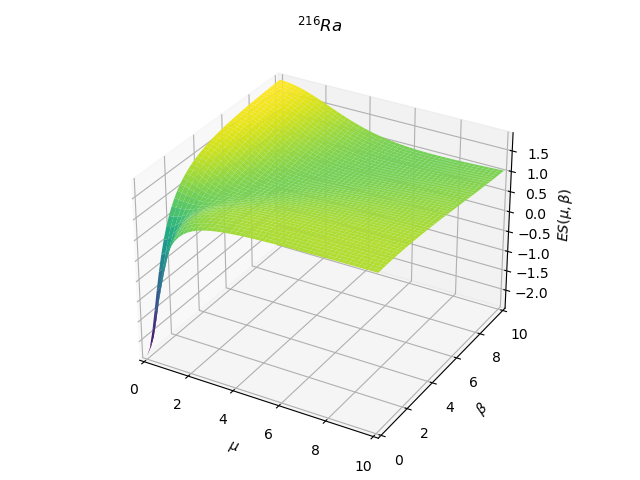

In [ ]:
from sympy import diff,Matrix,plot_implicit,minimum,Interval
from sympy.plotting import plot3d
%matplotlib widget
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# creating figure
#fig = plt.figure()
#ax = Axes3D(fig)
plot3d(function_h,(mu, 0, 10), (beta, 0, 10),title=r"${}^{216}Ra$",xlabel=r"$\mu$", ylabel=r"$\beta$", zlabel=r"$ES(\mu,\beta)$")

In [ ]:
stop
x = np.arange(0,4,0.01)
y = []
for i in x:
    y.append(function_h.subs({'Beta':0,'mu':i}))
#plt.plot(x,y)
plt.show()

NameError: name 'stop' is not defined

In [ ]:
stpop
# first derivate
dbeta = diff(function_h,beta)
dmu   = diff(function_h,mu)
# double derivate
dbetadbeta = diff(dbeta,beta)
dmudmu     = diff(dmu,beta)
# cross derivate
dbetadmu = diff(dbeta,mu)
dmudbeta = diff(dmu,beta)

hessian_matrix = Matrix(np.array([[dbetadbeta,dbetadmu],[dmudbeta,dmudmu]]))
#np.linalg.det(hessian_matrix) 
det_hessian = hessian_matrix.det()

NameError: name 'stpop' is not defined

In [ ]:
det_hessian.subs({'beta':0,'mu':0})

0